<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import time
import seaborn as sns 
import warnings
%pylab inline
warnings.filterwarnings(action="ignore")

plt.style.use('seaborn-darkgrid')
sns.set(font_scale=2)

np.random.seed(123456)
import os
os.chdir(r"C:\Solutions")
import pandas as pd
from sklearn.preprocessing import StandardScaler

palette = [
              "#030aa7","#e50000","#f5bf03","#005f6a","#6b7c85","#f5054f","#751973","#a0450e",
              "#0339f8","#f4320c","#fec615","#017a79","#85a3b2","#fe2f4a","#a00498","#b04e0f",
              "#0165fc","#ff724c","#fddc5c","#11875d","#89a0b0","#fe828c","#cb00f5","#b75203",
              "#0485d1","#ff7855","#fbeeac","#0cb577","#95a3a6","#ffb7ce","#c071fe","#ca6b02",
              "#92c5de","#f4a582","#fef69e","#18d17b","#c5c9c7","#ffcfdc","#caa0ff","#cb7723",
              "#d1e5f0","#fddbc7","#ffffcb","#12e193","#d8dcd6","#ffdaf0","#dfc5fe","#d8863b",
              "#030764","#be0119","#dbb40c","#005249","#3c4142","#cb0162","#5d1451","#653700",
              "#040348","#67001f","#b27a01","#002d04","#000000","#a0025c","#490648","#3c0008"
]

Populating the interactive namespace from numpy and matplotlib


In [2]:
def createAggregates(donnees,groupe,listeVariablesQ):
    nomGroupe = ''
    for col in groupe:
        nomGroupe += '_'+col
    nomGroupe = nomGroupe[1:]    
    noms =  list(np.array([ [nomGroupe+'_'+str(var)+'_'+'min',
              nomGroupe+'_'+str(var)+'_'+'max',
              nomGroupe+'_'+str(var)+'_'+'moy',
              nomGroupe+'_'+str(var)+'_'+'med',
              nomGroupe+'_'+str(var)+'_'+'ect',
              nomGroupe+'_'+str(var)+'_'+'skw',
              nomGroupe+'_'+str(var)+'_'+'krt',
              nomGroupe+'_'+str(var)+'_'+'amp',
              nomGroupe+'_'+str(var)+'_'+'01p',
              nomGroupe+'_'+str(var)+'_'+'05p',
              nomGroupe+'_'+str(var)+'_'+'25p',
              nomGroupe+'_'+str(var)+'_'+'75p',
              nomGroupe+'_'+str(var)+'_'+'95p',
              nomGroupe+'_'+str(var)+'_'+'99p',
              nomGroupe+'_'+str(var)+'_'+'iqr']
            for var in listeVariablesQ]).flatten())
    
    
    calc_df = donnees.groupby(
                                 groupe
                             ).agg(
                              { 
                                str(var):{
                                    pd.DataFrame.min               ,
                                    pd.DataFrame.max               ,
                                    pd.DataFrame.mean              ,
                                    pd.DataFrame.median            ,
                                    pd.DataFrame.std               ,
                                    pd.DataFrame.skew              ,
                                    pd.DataFrame.kurt              ,
                                    lambda x: max(x) - min(x)      ,
                                    lambda x: np.percentile(x, 1)  ,
                                    lambda x: np.percentile(x, 5)  ,
                                    lambda x: np.percentile(x, 25) ,
                                    lambda x: np.percentile(x, 75) ,
                                    lambda x: np.percentile(x, 95) ,
                                    lambda x: np.percentile(x, 99) ,
                                    lambda x: np.percentile(x, 75) - 
                                                  np.percentile(x, 25)
                                }
                                for var in listeVariablesQ
                               })
    calc_df.columns = noms
    calc_df.dropna(axis=1, inplace=True)
    
    valDesc = calc_df.describe().loc['std',:]
    calc_df.drop(columns=valDesc[valDesc == 0].index,inplace=True)

    #calc_df.columns = [str(x[1]) for x in calc_df.columns]
    calc_df.reset_index(inplace=True)

    return donnees.merge(calc_df,on=groupe,copy=False)

In [3]:
def createColumnsQualitatives(donnees,variable):
    noms_modalites = list(donnees[variable].unique())
    noms_modalites.sort()
    for i in noms_modalites:
        nom = variable+'_'+str(i)
        donnees[nom] = donnees[variable].apply(lambda x : 1 if x==i else 0)
    donnees.drop(labels=variable, axis=1, inplace=True)

In [4]:
donnees = pd.read_csv('donnees/creditCard.csv').iloc[:,1:]
donnees = donnees[~donnees.Time.isna()]

In [5]:
donnees.Time = donnees.Time.astype('int32')
donnees['DateOrigine'] = pd.to_datetime(donnees.Time, unit='s',origin=pd.Timestamp('2013-09-01T00:00:04.000000000'))
#donnees['Jour']        = donnees.DateOrigine.dt.day
donnees['Heure24']     = donnees.DateOrigine.dt.hour
#donnees['Minute']      = donnees.DateOrigine.dt.minute.apply(lambda x: round(x,-1))
#donnees['HeureMinute'] = donnees['Heure24'] + donnees.DateOrigine.dt.minute.apply(lambda x: round(x,-1))/100
#donnees['Minute30']    = round((donnees['Time'] / 60*30 ) % 47).astype('int8')
donnees['AmountLog']   = np.log(donnees.Amount+1)
#donnees['AmountInt']   = (donnees.Amount - donnees.Amount%1).astype('int32')
donnees['AmountDec']   = donnees.Amount%1
donnees['Temps']      = (donnees.Time - donnees.Time.shift(1)).fillna(0).astype('int8')
donnees.drop(columns=['Time','DateOrigine','Amount'],inplace=True)
#apply(lambda x: x + 1 if x > 5 else x + 24  )

In [6]:
donnees = createAggregates(donnees,['Heure24'],['AmountLog','Temps','AmountDec'])
#donnees = createAggregates(donnees,['HeureMinute'],['AmountLog','Temps','AmountDec'])
#donnees = createAggregates(donnees,['Minute30'],['AmountLog','Temps','AmountDec'])

In [7]:
donnees.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,Heure24_AmountDec_moy,Heure24_AmountDec_med,Heure24_AmountDec_ect,Heure24_AmountDec_krt,Heure24_AmountDec_01p,Heure24_AmountDec_05p,Heure24_AmountDec_25p,Heure24_AmountDec_95p,Heure24_AmountDec_99p,Heure24_AmountDec_iqr
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-1.59676,0.0,0.99,0.99,0.85,0.85,0.455604,0.47,0.072815,0.386162
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-1.59676,0.0,0.99,0.99,0.85,0.85,0.455604,0.47,0.072815,0.386162
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-1.59676,0.0,0.99,0.99,0.85,0.85,0.455604,0.47,0.072815,0.386162
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.59676,0.0,0.99,0.99,0.85,0.85,0.455604,0.47,0.072815,0.386162
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-1.59676,0.0,0.99,0.99,0.85,0.85,0.455604,0.47,0.072815,0.386162


In [8]:
createColumnsQualitatives(donnees,'Heure24')

In [9]:
donnees.columns.values

array(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'AmountLog', 'AmountDec', 'Temps', 'Heure24_AmountLog_min',
       'Heure24_AmountLog_max', 'Heure24_AmountLog_moy',
       'Heure24_AmountLog_med', 'Heure24_AmountLog_ect',
       'Heure24_AmountLog_skw', 'Heure24_AmountLog_amp',
       'Heure24_AmountLog_01p', 'Heure24_AmountLog_05p',
       'Heure24_AmountLog_25p', 'Heure24_AmountLog_75p',
       'Heure24_AmountLog_95p', 'Heure24_AmountLog_99p',
       'Heure24_AmountLog_iqr', 'Heure24_Temps_min', 'Heure24_Temps_max',
       'Heure24_Temps_moy', 'Heure24_Temps_med', 'Heure24_Temps_ect',
       'Heure24_Temps_skw', 'Heure24_Temps_01p', 'Heure24_Temps_05p',
       'Heure24_Temps_75p', 'Heure24_Temps_95p', 'Heure24_Temps_99p',
       'Heure24_Temps_iqr', 'Heure24_AmountDec_moy',
       'Heure24_AmountDec_med', 'Heur

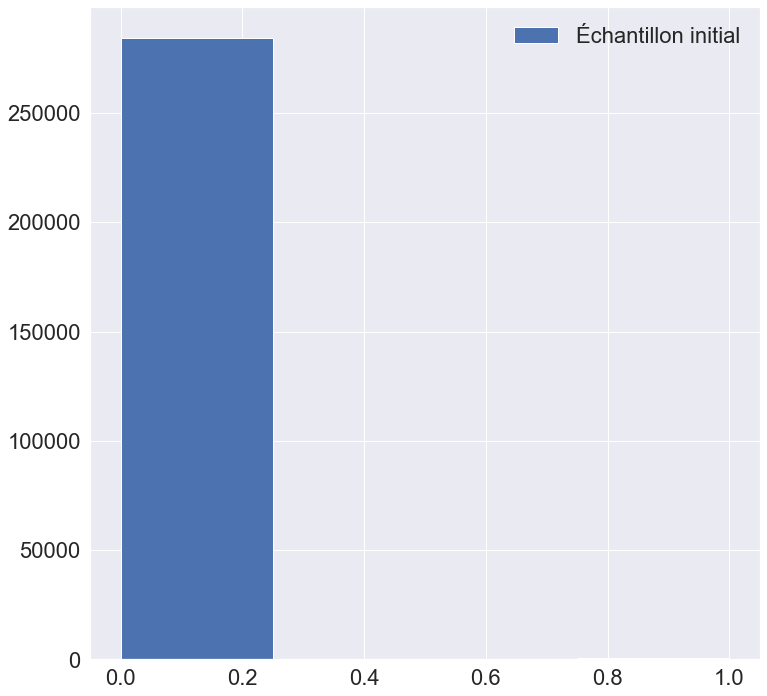

In [10]:
donnees.Class.hist(bins=4, figsize=(12,12),label="Échantillon initial");
plt.legend();

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority', n_jobs=-1)
X_sampling, y_sampling = smote.fit_resample(donnees.drop(columns='Class').values,donnees.Class)

X_SMOTE = pd.DataFrame(X_sampling, columns=donnees.drop(columns='Class').columns)
X_SMOTE['Class'] = y_sampling

Using TensorFlow backend.


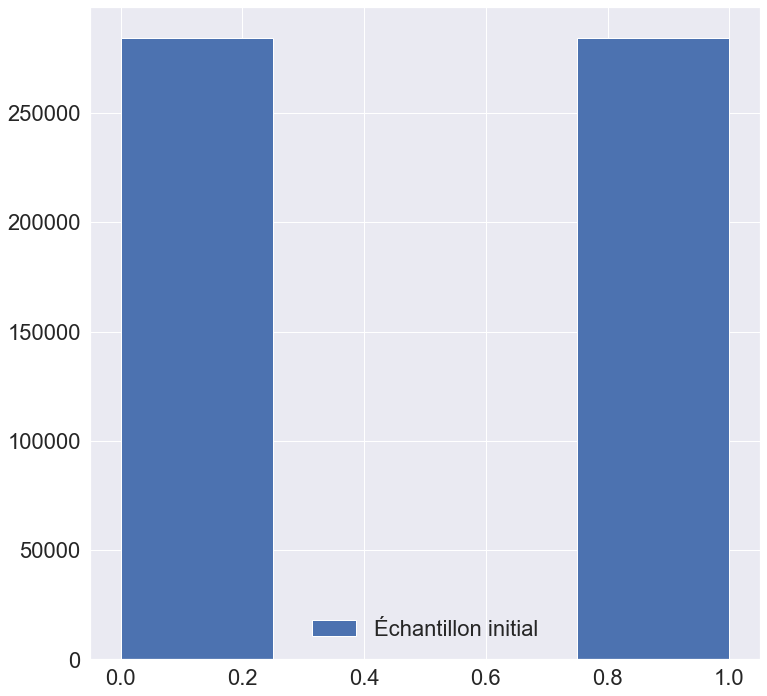

In [13]:
X_SMOTE.Class.hist(bins=4, figsize=(12,12),label="Échantillon initial");
plt.legend();

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                                    X_SMOTE.drop(columns='Class'), 
                                                    X_SMOTE.Class, test_size=0.4, 
                                                    random_state=0, 
                                                    stratify = X_SMOTE.Class) 

X_train.shape, X_test.shape

((341176, 91), (227452, 91))

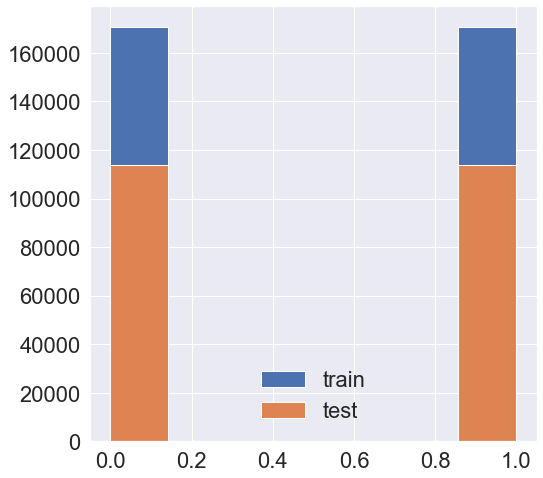

In [15]:
y_train.hist(bins=7, figsize=(8,8), label='train');
y_test.hist(bins=7, figsize=(8,8), label='test');
plt.legend();

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc

names = ["Decision Tree", 
         "Random Forest",
         "AdaBoost",
         #"Nearest Neighbors", 
         #"Linear SVM", 
         #"RBF SVM", #"Gaussian Process",
         #"Neural Net", 
         #"Naive Bayes", 
         #"QDA"
        ]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, 
                           n_estimators=100, max_features=4),    
    AdaBoostClassifier(n_estimators=100),    
    #KNeighborsClassifier(10),
    #SVC(kernel="linear", C=0.025, probability=True),
    #SVC(gamma=0.001, C=0.025, probability=True),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    #MLPClassifier(alpha=1),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()
]

Decision Tree     95.4834	--	Area under the ROC curve : 0.9845	--	Exécution  :11.31s
Random Forest     93.2469	--	Area under the ROC curve : 0.9942	--	Exécution  :41.01s
AdaBoost          99.3111	--	Area under the ROC curve : 0.9998	--	Exécution  :266.45s


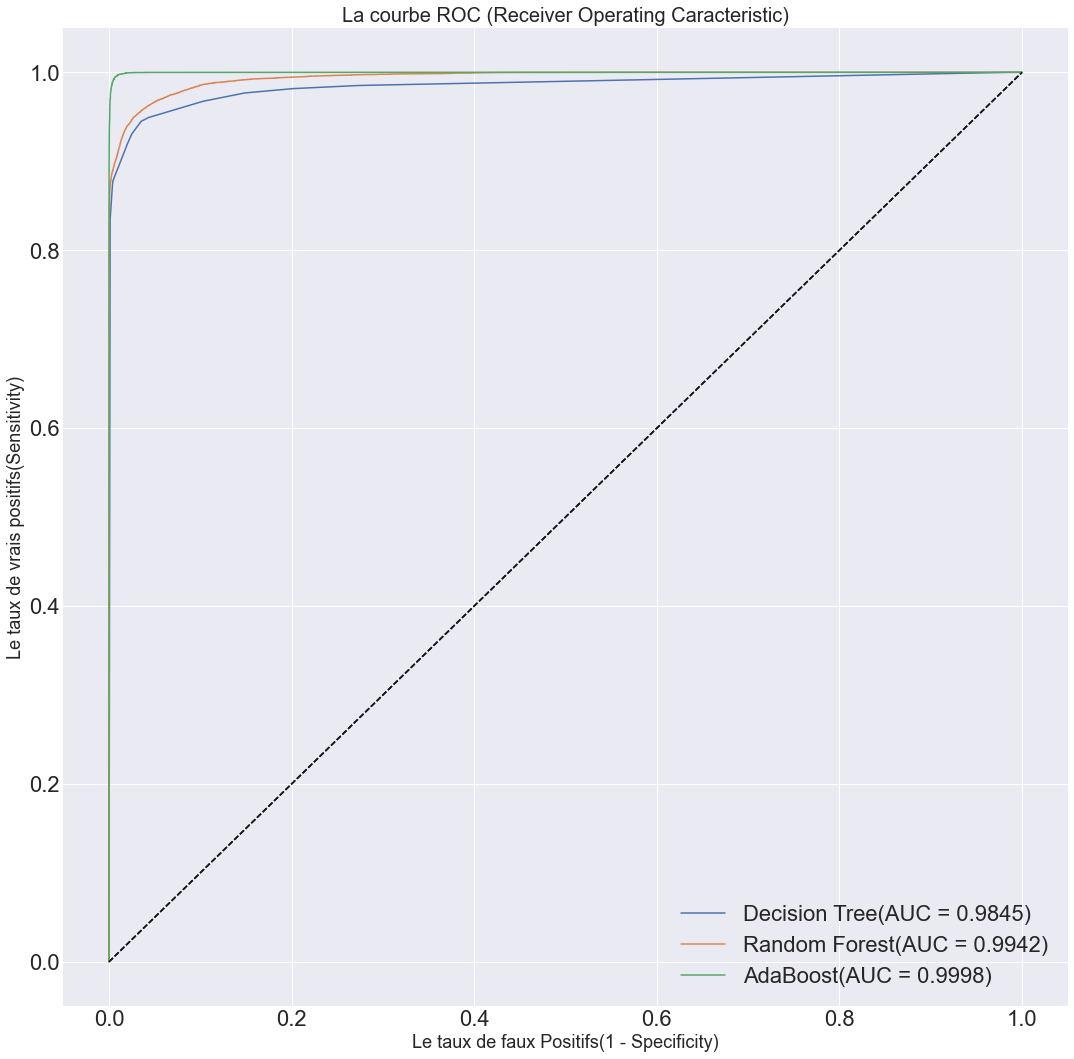

Exécution  :318.99s


In [17]:
np.random.seed(123456)
t0 = time.time()  
h = .02  # step size in the mesh

import seaborn as sns
plt.figure(figsize=(18,18))
plt.style.use('seaborn-darkgrid')

for name, clf in zip(names, classifiers):
    t1 = time.time()  
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)*100
    print(f'{name:17s}'+(' %.4f' % score).lstrip('0'),end='\t--\t')
    probas = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test.ravel(), probas[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %0.4f" % roc_auc,end='\t--\t')
    plt.plot(fpr, tpr, label=name + '(AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Le taux de faux Positifs(1 - Specificity)',size=18)
    plt.ylabel('Le taux de vrais positifs(Sensitivity)',size=18)
    plt.title('La courbe ROC (Receiver Operating Caracteristic)',size=20)
    plt.legend(loc="lower right")
    print('Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0'))
plt.show()
      
print('Exécution  :'+('%.2fs' % (time.time() - t0)).lstrip('0'))

In [18]:
y_pred = classifiers[2].predict(X_test)

In [19]:
from sklearn.metrics                  import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                                            precision_score, recall_score, f1_score, jaccard_score,  \
                                            precision_recall_curve, average_precision_score

In [20]:
def afficheMetrics( y_test, y_pred):
    accuracy                 = accuracy_score (y_test,y_pred)
    logloss                  = log_loss       (y_test,y_pred)
    hammingloss              = hamming_loss   (y_test,y_pred)
    precision                = precision_score(y_test,y_pred)
    sensibilite              = recall_score   (y_test,y_pred)
    f1                       = f1_score       (y_test,y_pred)
    jaccard                  = jaccard_score  (y_test,y_pred)
    vrais_negatifs           = confusion_matrix(y_test, y_pred)[0, 0]
    faux_positifs            = confusion_matrix(y_test, y_pred)[0, 1]
    faux_negatifs            = confusion_matrix(y_test, y_pred)[1, 0]
    vrais_positifs           = confusion_matrix(y_test, y_pred)[1, 1]

    print(
          " accuracy           : %.2f%%\n" % (accuracy * 100.0),       
          "sensibilité/rappel : %.6f\n" % sensibilite       ,
          "précision          : %.6f\n" % precision         ,
          "f1                 : %.6f\n" % f1                ,
          "-"*20,
          "\n logloss            : %.6f\n" % logloss           ,
          "hammingloss        : %.6f\n" % hammingloss       ,
          "jaccard            : %.6f\n" % jaccard           ,
          "-"*20,
          "\n vrais_negatifs     : %.6f\n" % vrais_negatifs    ,
          "faux_positifs      : %.6f\n" % faux_positifs     ,
          "faux_negatifs      : %.6f\n" % faux_negatifs     ,
          "vrais_positifs     : %.6f\n" % vrais_positifs    
         )

    classificationMetrics   =     {
        'accuracy'       :accuracy   ,
        'sensibilite'    :sensibilite, 
        'precision'      :precision  , 
        'f1'             :f1         , 
        'logloss'        :logloss    , 
        'hammingloss'    :hammingloss, 
        'jaccard'        :jaccard    , 
        'vrais_negatifs' :vrais_negatifs ,
        'faux_positifs'  :faux_positifs  ,
        'faux_negatifs'  :faux_negatifs  ,
        'vrais_positifs' :vrais_positifs    
        }     
    return classificationMetrics

In [21]:
afficheMetrics( y_test, y_pred)

 accuracy           : 99.31%
 sensibilité/rappel : 0.991066
 précision          : 0.995135
 f1                 : 0.993097
 -------------------- 
 logloss            : 0.237952
 hammingloss        : 0.006889
 jaccard            : 0.986288
 -------------------- 
 vrais_negatifs     : 113175.000000
 faux_positifs      : 551.000000
 faux_negatifs      : 1016.000000
 vrais_positifs     : 112710.000000



{'accuracy': 0.9931106343316392,
 'sensibilite': 0.9910662469444103,
 'precision': 0.9951351303626138,
 'f1': 0.9930965209461334,
 'logloss': 0.23795219733838036,
 'hammingloss': 0.006889365668360797,
 'jaccard': 0.9862877044374634,
 'vrais_negatifs': 113175,
 'faux_positifs': 551,
 'faux_negatifs': 1016,
 'vrais_positifs': 112710}

In [22]:
confusion_matrix(y_test, y_pred)

array([[113175,    551],
       [  1016, 112710]], dtype=int64)

In [23]:
def afficheImportanceVariables(classifieur, X, nom = 'RF'):
    importances = pd.DataFrame(X.columns, columns=['nom'])
    importances['importance'] = classifieur.feature_importances_
    importances.sort_values(by='importance',ascending=False, inplace=True)

    sns_plot = sns.catplot(x='nom', y='importance',data=importances, kind='bar', size=18,  aspect=4);
    loc, labels = plt.xticks()
    sns_plot.set_xticklabels(labels, rotation=90);
    #self.sauvegarderImage(self.nom_projet+f'--ImportanceVariables--Classifieur--{nom:s}--'+time.strftime("%Y%m%d-%H.%M.%S"))
    plt.show()
    return importances


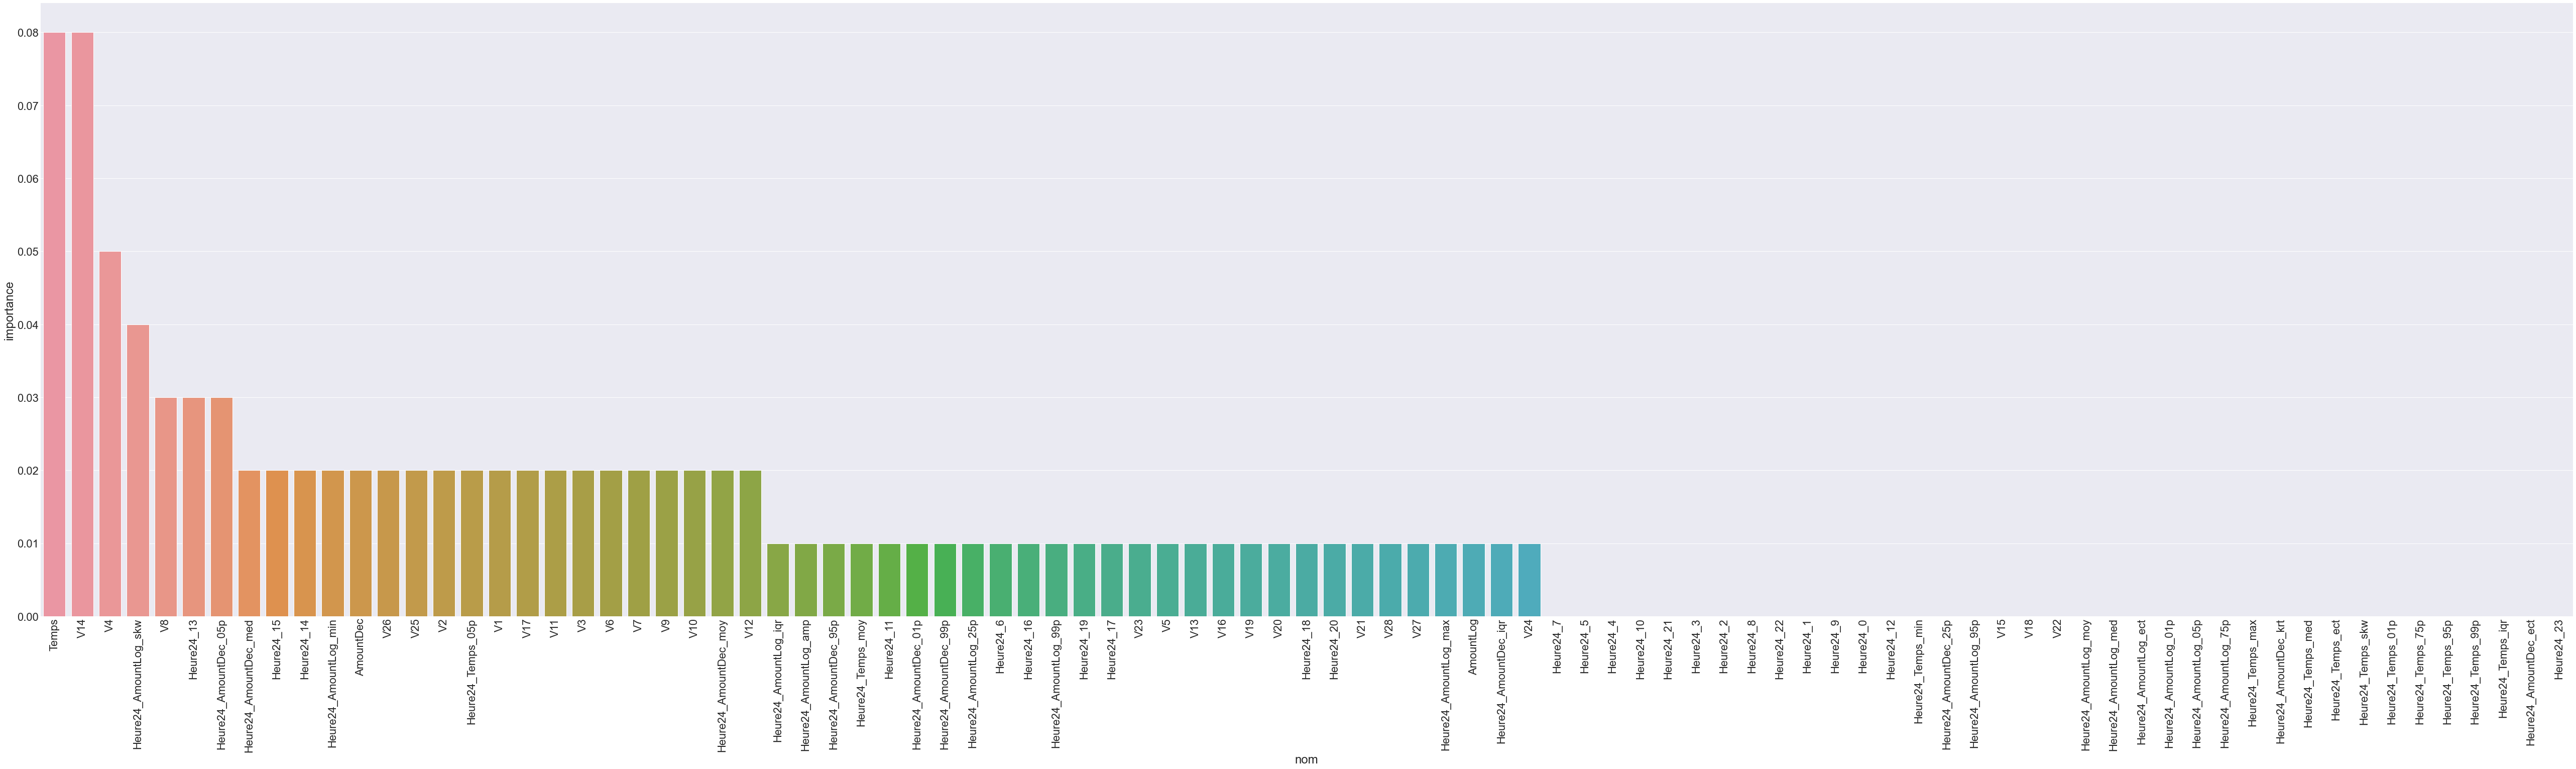

,nom,importance
30,Temps,0.08
13,V14,0.08
3,V4,0.05
36,Heure24_AmountLog_skw,0.04
7,V8,0.03
...,...,...
54,Heure24_Temps_95p,0.00
55,Heure24_Temps_99p,0.00
56,Heure24_Temps_iqr,0.00
59,Heure24_AmountDec_ect,0.00


In [24]:
afficheImportanceVariables(classifiers[2],X_test)

In [ ]:
donnees.groupby('Heure24').agg(AmountLog_min=pd.NamedAgg(column='AmountLog', aggfunc='min'))

In [ ]:
donnees[['Class', 'Temps', 'Amount',
         'Heure24', 'HeureMinute', 'Minute30', 'AmountLog', 'AmountDec']]

In [ ]:
donnees[['Class', 'Temps', 'Amount',
         'Heure24', 'HeureMinute', 'Minute30', 'AmountLog', 'AmountDec']].describe()

In [ ]:
donnees[['Class','Time','Temps', 'Amount',
       'Heure24', 'HeureMinute',
       'Minute30', 'AmountLog', 'AmountDec']][(donnees.AmountDec > 0)&
                                              (donnees.AmountDec < 0.02)&
                                              (donnees.Class == 0)].describe()

In [ ]:
plt.figure(figsize=(24,16))
sns.violinplot(x='HeureMinute',y='AmountDec',data=donnees,hue='Class',split=True,palette=palette);

In [ ]:
plt.figure(figsize=(24,16))
sns.violinplot(x='Heure24',y='AmountLog',data=donnees,hue='Class',split=True,palette=palette);

In [ ]:
plt.figure(figsize=(24,8))
sns.barplot(x='Heure24', 
               y='Temps',
               hue='Class',
               data=donnees,
               estimator=mean,
               #alpha=0.9,
               palette=palette
              );

In [ ]:
plt.figure(figsize=(24,8))
sns.barplot(x='Minute30', 
               y='Temps',
               hue='Class',
               data=donnees,
               estimator=mean,
               #alpha=0.9,
               palette=palette
              );

In [ ]:
plt.figure(figsize=(24,8))
sns.barplot(x='Heure24', 
               y='Amount',
               hue='Class',
               data=donnees,
               estimator=mean,
               #alpha=0.9,
               palette=palette
              );

In [ ]:
plt.figure(figsize=(24,8))
sns.barplot(x='Minute30', 
               y='Amount',
               hue='Class',
               data=donnees,
               estimator=mean,
               #alpha=0.9,
               palette=palette
              );

In [ ]:
plt.figure(figsize=(56,12))
ax = sns.barplot(x='HeureMinute', 
               y='AmountLog',
               hue='Class',
               data=donnees,
               estimator=mean,
               #alpha=0.9,
               palette=palette
              );
ax.set_xticklabels(donnees.HeureMinute.unique(),rotation=90);

In [ ]:
'Time', 'Amount',
       'Class', 'DateOrigine', 'Jour', 'Heure24', 'Minute', 'HeureMinute',
       'Minute30', 'AmountLog', 'AmountInt', 'AmountDec'

In [ ]:
g = sns.catplot("HeureMinute", data=donnees[(donnees.Class == 1)], aspect=1.5, kind="count", color="b", size=30)
g.set_xticklabels(rotation=90);

In [ ]:
plt.figure(figsize=(48,16))
sns.violinplot(x='HeureMinute',y='AmountDec',data=donnees[(donnees.Class >= 0)],hue='Class',split=True);

In [ ]:
plt.figure(figsize=(24,16))
sns.violinplot(x='Heure24',y='AmountLog',data=donnees[(donnees.Class >= 0)],hue='Jour',split=True);

In [ ]:
donnees[(donnees.Amount == 0)&(donnees.Class == 1)].count()

In [ ]:
plt.figure(figsize=(24,16))
sns.violinplot(x='Heure24',y='AmountLog',data=donnees[(donnees.Class == 0)],hue='Jour',split=True);

In [ ]:
plt.figure(figsize=(24,16))
sns.violinplot(x='Minute30',y='AmountLog',data=donnees[(donnees.Class == 1)],hue='Jour',size=30);

In [ ]:
g = sns.catplot("Minute30", data=donnees[(donnees.Class == 1)], aspect=1.5, kind="count", color="b", size=30)
g.set_xticklabels(rotation=90);

In [ ]:
g = sns.catplot("HeureMinute", data=donnees[(donnees.Class == 1)], aspect=1.5, kind="count", color="b", size=30)
g.set_xticklabels(rotation=90);

In [ ]:
plt.figure(figsize=(18,8))
sns.distplot(donnees.HeureMinute[(donnees.Class == 1)],color='red',bins=144);

In [ ]:
plt.figure(figsize=(18,8))
sns.distplot(donnees.HeureMinute[(donnees.Class == 0)],color='blue',bins=24);

In [ ]:
plt.figure(figsize=(18,8))
sns.distplot(donnees.Amount[(donnees.Class == 1)],color='red');

In [ ]:
plt.figure(figsize=(18,8))
sns.distplot(donnees.AmountDec[(donnees.Class == 1)],color='red');

In [ ]:
plt.figure(figsize=(18,8))
sns.distplot(donnees.AmountDec[(donnees.Class == 0)],color='blue');

In [ ]:
plt.figure(figsize=(14,12))

sns.distplot(donnees.AmountLog[(donnees.Class == 1)], label='Fraude',color='red')
sns.distplot(donnees.AmountLog[(donnees.Class == 0)], label='Valide',color='blue')
plt.legend()

In [ ]:
donnees['AmountInt'] = (donnees.Amount - donnees.Amount%1).astype('int32')
donnees['AmountDec'] = donnees.Amount%1

In [ ]:
plt.figure(figsize=(14,12))

sns.distplot(donnees.AmountInt[(donnees.Amount < 200)&
                                (donnees.Class == 1)], label='Fraude',color='red')
sns.distplot(donnees.AmountInt[(donnees.Amount < 200)&
                                (donnees.Class == 0)], label='Valide',color='blue')
plt.legend()

In [ ]:
plt.figure(figsize=(14,12))

sns.distplot(donnees.AmountDec[#(donnees.Amount < 100)&
                                (donnees.Class == 1)], label='Fraude',color='red')
sns.distplot(donnees.AmountDec[#(donnees.Amount < 100)&
                                (donnees.Class == 0)], label='Valide',color='blue')
plt.legend()    
#plt.show()    

In [ ]:
plt.figure(figsize=(14,12))
sns.distplot(donnees.DateOrigine)

In [ ]:
plt.figure(figsize=(14,12))
sns.distplot(donnees.Heure24,bins=23)

In [ ]:
plt.figure(figsize=(14,12))
sns.distplot(donnees.DateOrigine)

In [ ]:
plt.figure(figsize=(14,12))
sns.distplot(donnees.Time/3600%23)

In [ ]:
donnees.head()

In [ ]:
donnees = pd.read_csv('donnees/creditCard.csv').iloc[:,1:]
donnees = donnees[~donnees.Time.isna()]
donnees.Time = round((donnees['Time'] / 3600) % 23).astype('int8')
donnees.head()

In [ ]:
donnees.shape

In [ ]:
pd.crosstab(donnees.Class,1)

In [ ]:
donnees.Time.unique()

In [ ]:
plt.figure(figsize=(14,12))

for i in range(24):
    sns.distplot(donnees.Amount[(donnees.Time == i) &
                                #(donnees.Amount < 250) &
                                (donnees.Class == 1) ], label=str(i))

plt.legend();    
plt.show()    

In [ ]:
plt.figure(figsize=(14,12))

sns.distplot(donnees.Heure28[#(donnees.Amount < 100)&
                                (donnees.Class == 1)], label='Fraude')
sns.distplot(donnees.Heure28[#(donnees.Amount < 100)&
                                (donnees.Class == 0)], label='Valide')
plt.legend()    
#plt.show()    

In [ ]:
X = (donnees.Amount - donnees.Amount.mean())/donnees.Amount.std()

In [ ]:
donnees.Amount.min(),donnees.Amount.max()

In [ ]:
plt.figure(figsize=(24,18))
sns.boxplot(x='Heure24',y='Amount', data=donnees,hue='Class')

In [ ]:
sns.set(font_scale=3)
sns.jointplot(x='Heure28',y='Amount', data=donnees, size=25)

In [ ]:
plt.figure(figsize=(14,12))
sns.distplot(np.log(donnees.Amount[donnees.Class == 0]+1), label='Valid', color='blue')
sns.distplot(np.log(donnees.Amount[donnees.Class == 1]+1), label='Fraude',color='red')
plt.legend()

In [ ]:
pd.crosstab(donnees.Class,1)

In [ ]:
284314 / donnees.shape[0]

In [ ]:
284314 / 23

In [ ]:
23*300

In [ ]:
donnees.Cible.unique()
cap_color =list(donnees.cap_color.unique())
cap_color.sort()
cap_color

In [ ]:
from sklearn.preprocessing import LabelEncoder
import copy as cp
modelsLEd = {} 

for col in donnees.columns:
    labelencoder=LabelEncoder()
    labelencoder.fit(donnees[col])
    modelsLEd[col] = cp.deepcopy(labelencoder)

In [ ]:
modelsLEd

In [ ]:
import pickle
pickle_file = "champignonsLE.pickle"

with open(pickle_file, 'wb') as f:
    pickle.dump( modelsLEd,f)


In [ ]:
pickle_file = "champignonsLE.pickle"

with open(pickle_file, 'rb') as f:
    modelsLEd = pickle.load(f)


In [ ]:
donnees.head() 

In [ ]:
for col in donnees.columns:
    donnees[col] = modelsLEd[col].transform(donnees[col])
    
donnees.head() 

In [ ]:
plt.figure(figsize=(28,28))
sns.set(font_scale=2)
plt.title('Correlation Spearman des variables', y=1.05, size=24)
sns.heatmap(donnees.corr(method='spearman'), fmt= '.1f',linewidths=0.3,vmax=1.0, 
            square=True, cmap='coolwarm', linecolor='white', annot=True);

In [ ]:
donnees.columns

In [ ]:
donnees.shape

In [ ]:
donnees.reset_index().head()

In [ ]:
donnees.drop(columns='Cible').head()

In [ ]:
import pickle
pickle_file = "champignons.Index.pickle"

with open(pickle_file, 'rb') as f:
    indexTrain = pickle.load(f)
    indexTest  = pickle.load(f)

In [ ]:
X_train, X_test, y_train, y_test = donnees.filter(items=indexTrain,axis=0).drop(columns=['Cible'],axis=1),\
                                   donnees.filter(items=indexTest ,axis=0).drop(columns=['Cible'],axis=1),\
                                   donnees.filter(items=indexTrain,axis=0).Cible,\
                                   donnees.filter(items=indexTest ,axis=0).Cible
X_train.shape, X_test.shape

In [ ]:
y_train.hist(bins=7, figsize=(8,8), label='train');
y_test.hist(bins=7, figsize=(8,8), label='test');
plt.legend();

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc

names = ["Decision Tree", 
         "Random Forest",
         "AdaBoost",
         "Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", #"Gaussian Process",
         "Neural Net", 
         "Naive Bayes", 
         "QDA"]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, 
                           n_estimators=10000, max_features=4),    
    AdaBoostClassifier(n_estimators=10000),    
    KNeighborsClassifier(10),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=0.001, C=0.025, probability=True),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=1),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
np.random.seed(123456)
t0 = time.time()  
h = .02  # step size in the mesh

import seaborn as sns
plt.figure(figsize=(18,18))
plt.style.use('seaborn-darkgrid')

for name, clf in zip(names, classifiers):
    t1 = time.time()  
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)*100
    print(f'{name:17s}'+(' %.4f' % score).lstrip('0'),end='\t--\t')
    probas = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test.ravel(), probas[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %0.4f" % roc_auc,end='\t--\t')
    plt.plot(fpr, tpr, label=name + '(AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Le taux de faux Positifs(1 - Specificity)',size=18)
    plt.ylabel('Le taux de vrais positifs(Sensitivity)',size=18)
    plt.title('La courbe ROC (Receiver Operating Caracteristic)',size=20)
    plt.legend(loc="lower right")
    print('Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0'))
plt.show()
      
print('Exécution  :'+('%.2fs' % (time.time() - t0)).lstrip('0'))

In [ ]:
donnees01 = cp.deepcopy(donneesSav )
for col in donnees01.drop(columns='Cible').columns:
    createColumnsQualitatives(donnees01,col)
    
donnees01.Cible = donnees01.Cible.map(lambda x : 1 if x == 'p' else 0)

In [ ]:
donnees01.head()

In [ ]:
X_train, X_test, y_train, y_test = donnees01.filter(items=indexTrain,axis=0).drop(columns=['Cible'],axis=1),\
                                   donnees01.filter(items=indexTest ,axis=0).drop(columns=['Cible'],axis=1),\
                                   donnees01.filter(items=indexTrain,axis=0).Cible,\
                                   donnees01.filter(items=indexTest ,axis=0).Cible
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
y_train.hist(bins=7, figsize=(8,8), label='train');
y_test.hist(bins=7, figsize=(8,8), label='test');
plt.legend();

In [ ]:
np.random.seed(123456)
t0 = time.time()  
h = .02  # step size in the mesh

import seaborn as sns
plt.figure(figsize=(18,18))
plt.style.use('seaborn-darkgrid')

for name, clf in zip(names, classifiers):
    t1 = time.time()  
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)*100
    print(f'{name:17s}'+(' %.4f' % score).lstrip('0'),end='\t--\t')
    probas = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test.ravel(), probas[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %0.4f" % roc_auc,end='\t--\t')
    plt.plot(fpr, tpr, label=name + '(AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Le taux de faux Positifs(1 - Specificity)',size=18)
    plt.ylabel('Le taux de vrais positifs(Sensitivity)',size=18)
    plt.title('La courbe ROC (Receiver Operating Caracteristic)',size=20)
    plt.legend(loc="lower right")
    print('Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0'))
plt.show()
      
print('Exécution  :'+('%.2fs' % (time.time() - t0)).lstrip('0'))